In [1]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_array, check_is_fitted

import numpy as np
import matplotlib.pyplot as plt
import os
import copy
import inspect
import random

from scipy import optimize, ndimage
from sklearn import decomposition, cluster, model_selection, metrics
import sklearn
import warnings
warnings.filterwarnings(action='ignore')

In [86]:
def unit_vector_norm(X):
    return (X.T / np.sqrt((X**2).sum(axis=1))).T

def blur_norm(X, s):
    return ndimage.gaussian_filter(X, (s,s,0))

def mu_norm(X):
    return X - X.mean(0)

In [117]:
# use 368 to 1750
s = 1
start_index, end_index = 115, 815
X = blur_norm(np.load("../data/HSI/Liver_map_150z25_60s_1TCPOBOP.npy", 'r')[:,:,start_index: end_index], s)
Y = blur_norm(np.load("../data/HSI/Liver_map_150z25_60s_2TCPOBOP.npy", 'r')[:,:,start_index: end_index], s)
Z = blur_norm(np.load("../data/HSI/Liver_map_150z25_60s_3OBOB.npy", 'r')[:,:,start_index: end_index], s)
wavelength = np.load("../data/HSI/wavelength.npy", 'r')[start_index: end_index]

shape_X = X.shape 
shape_Y = Y.shape 
shape_Z = Z.shape 

X = copy.copy(X.reshape(-1, X.shape[-1]))
Y = copy.copy(Y.reshape(-1, Y.shape[-1]))
Z = copy.copy(Z.reshape(-1, Z.shape[-1]))

In [177]:
class ReferenceVectorClassifierPCA(BaseEstimator):
    def __init__(self, **kwargs):
        self.kwargs = {}
        self.pca_kwargs = {}
        self.k_means_kwargs = {}        
        self.set_params(**kwargs)
        
    def fit(self, x, **kwargs):
        self.set_params(**kwargs)
        X = unit_vector_norm(x)
        
        ###################### PCA ################################
        self.pca = decomposition.PCA(**self.pca_kwargs)
        self.pca.fit(X)
        z = self.pca.transform(X)
        self.z = z

        ###################### clustering ################################
        self.clusters = cluster.KMeans(**self.k_means_kwargs).fit(z)
        self.clusters = self.clusters.labels_
        
        one_hot = np.zeros((X.shape[0], self.kwargs['n_clusters']), dtype=bool)
        one_hot[range(X.shape[0]), self.clusters] = 1

        ###################### reference spectra ################################  
        self.reference_spectra_ = unit_vector_norm(np.array([np.abs(x_) for i, x_ in enumerate(one_hot.T @ X)]))
        self.ref_org = np.array([x[one_hot[:,i],:].mean(axis=0) for i in range(self.kwargs['n_clusters'])])
                     
        # Return the classifier
        return self

    def predict(self, X):
        """
        predict transforms the data into the reference space. Min weight should be 0 or higher then 'min_weight'
        The error is the NMSE, where the MSE is normalised by the signal strength. 
        error.shape = X.shape[0], so for each data point the error is calculated.
        """
        # Check is fit had been called
        check_is_fitted(self)

        # Input validation
        X = check_array(X)
        X = unit_vector_norm(X)
                
        ###################### RCA ################################
        old_mask = np.zeros((X.shape[0], self.kwargs['n_clusters']), dtype=bool)
        mask = np.ones((X.shape[0], self.kwargs['n_clusters']), dtype=bool)
        while np.abs(old_mask ^ mask).sum():
            RCA_vector = np.array([optimize.nnls(self.reference_spectra_.T * mask[i], X[i,:])[0] for i in range(X.shape[0])])
            old_mask, mask = mask, (RCA_vector.T / RCA_vector.sum(axis=1)).T >= self.kwargs['min_weight']    
        
        return RCA_vector  
    
    def get_reference_vectors(self):
        return self.reference_spectra_
    
    def get_org_reference_vectors(self):
        return self.ref_org

    def get_params(self, deep=False):
        return self.kwargs
    
    def set_params(self, **kwargs):
        self.kwargs.update(kwargs)
        self.pca_kwargs.update({k:v  for k,v in kwargs.items() if k in list(inspect.signature(decomposition.PCA).parameters.keys())})
        self.k_means_kwargs.update({k:v  for k,v in kwargs.items() if k in list(inspect.signature(cluster.KMeans).parameters.keys())})     
        return self

In [178]:
def error_map(estimator, X, y=None):
    RCA = estimator.predict(X)
    ref_vec = estimator.get_reference_vectors()
    return ((RCA @ ref_vec - X)**2).mean(1)

def score_func(estimator, X, y=None):  
    X = unit_vector_norm(X)
    return error_map(estimator, X).mean()

def print_mean_std(X):
    return f"{X.mean():<12.4e}{X.std():<12.4e}"

def cross_val_X_Y_Z(rvc, X, Y, Z):
    rvc.fit(np.concatenate((X, Y), axis=0))
    return score_func(rvc, Z)


In [179]:
kwargs = {'n_clusters': 3,
          'n_components': 6,
          'min_weight': 0}

header = f"{'mean':12}{'std':12}"

In [180]:
# ################################# cross_val_score #######################
# rvc = ReferenceVectorClassifierPCA(**kwargs)
# print(f"{'':18}| {header}")
# print(f"cross_val_score X | {print_mean_std(model_selection.cross_val_score(rvc, X, None, scoring=score_func))}")
# print(f"cross_val_score Y | {print_mean_std(model_selection.cross_val_score(rvc, Y, None, scoring=score_func))}")
# print(f"cross_val_score Z | {print_mean_std(model_selection.cross_val_score(rvc, Z, None, scoring=score_func))}")

In [181]:
# ################################# cross_val_score #######################
# rvc = ReferenceVectorClassifierPCA(**kwargs)
# print(f"{'':25}| {header}")
# print(f"cross_val_score X&Y -> Z | {print_mean_std(cross_val_X_Y_Z(rvc, X, Y, Z))}")
# print(f"cross_val_score Y&Z -> X | {print_mean_std(cross_val_X_Y_Z(rvc, Y, Z, X))}")
# print(f"cross_val_score Z&X -> Y | {print_mean_std(cross_val_X_Y_Z(rvc, Z, X, Y))}")

[[-0.03794452  0.67946008  0.35758211]
 [-0.06702311  0.48108029  0.58506126]
 [-0.07571519  0.29153254  0.7834017 ]
 ...
 [ 1.13177482 -0.43467685  0.29710511]
 [ 1.11380902 -0.42341015  0.30420462]
 [ 1.09479132 -0.43544952  0.33540946]]


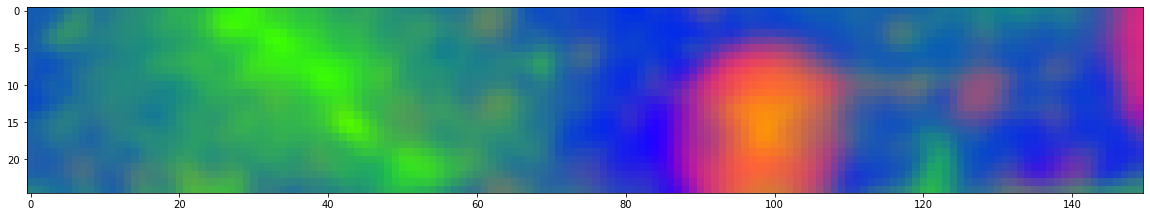

fit score:  8.470409169360327e-07


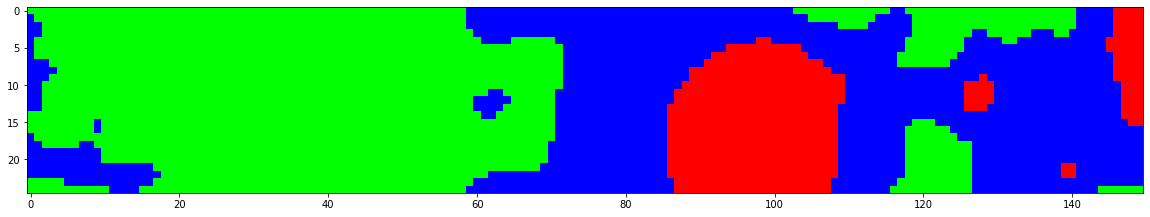

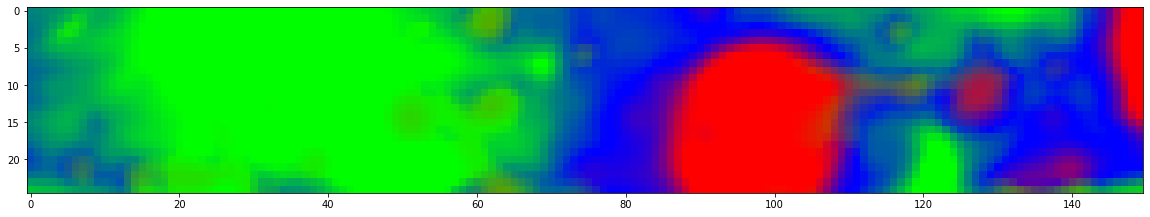

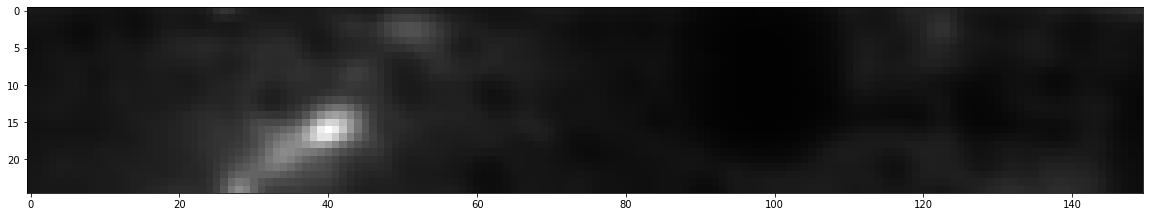

In [191]:
################# predict on original image ###############################
rvc = ReferenceVectorClassifierPCA(**kwargs)
rvc.fit(X)

RCA_vector = rvc.predict(X)

print("fit score: ", score_func(rvc, X))

one_hot = np.zeros((X.shape[0], rvc.kwargs['n_clusters']), dtype=float)
one_hot[range(X.shape[0]), rvc.clusters] = 1

plt.figure(figsize = (20,4))
plt.imshow(np.swapaxes(one_hot.reshape((*shape_X[:2], kwargs['n_clusters'])),0,1)[::-1,:,:3])
plt.show()

RCA_vector -= RCA_vector.min(0)
RCA_vector /= RCA_vector.max(0)
plt.figure(figsize = (20,4))
plt.imshow(np.swapaxes(RCA_vector.reshape((*shape_X[:2], kwargs['n_clusters'])),0,1)[::-1,:,:3])
plt.show()
# plt.figure(figsize = (20,4))
# plt.imshow(np.swapaxes(RCA_vector.reshape((*shape_X[:2], kwargs['n_clusters'])),0,1)[::-1,:,3:6])
# plt.show()
# plt.figure(figsize = (20,4))
# plt.imshow(np.swapaxes(RCA_vector.reshape((*shape_X[:2], kwargs['n_clusters'])),0,1)[::-1,:,6:9])
# plt.show()
plt.figure(figsize = (20,4))
plt.imshow(error_map(rvc, X).reshape(shape_X[:2]).T, cmap='gray', vmin=0)
plt.show()


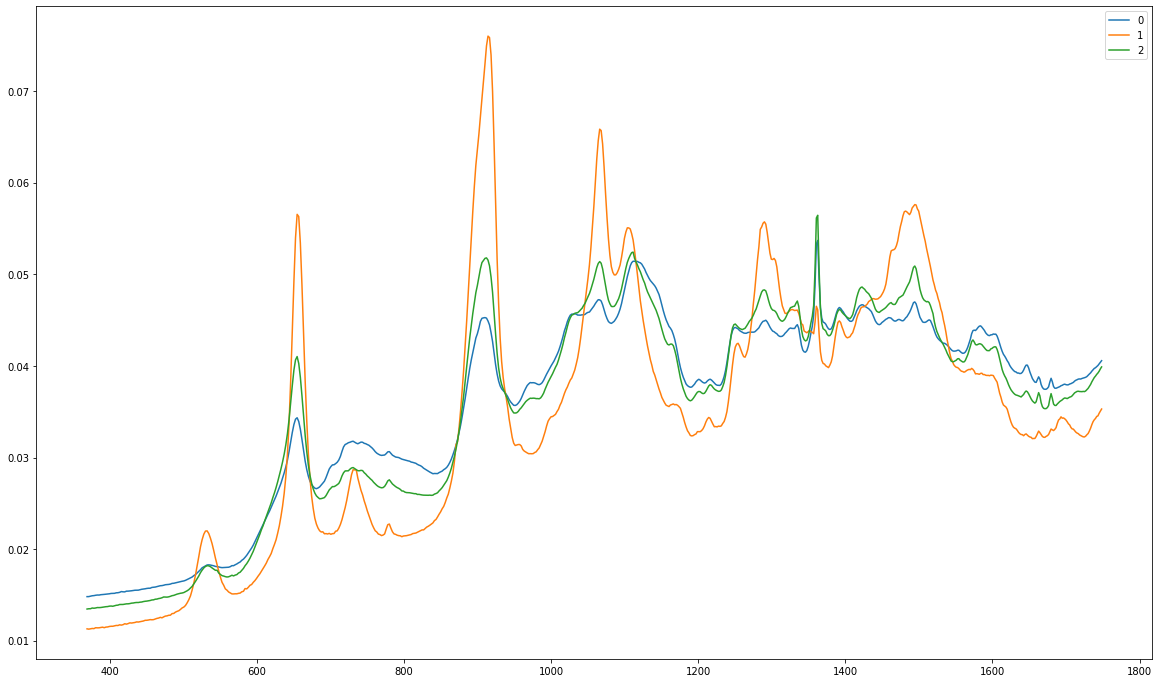

In [184]:
plt.figure(figsize = (20,12))
for i, r in enumerate(rvc.get_reference_vectors()):
    plt.plot(wavelength, r, label=i)
plt.legend()
plt.show()

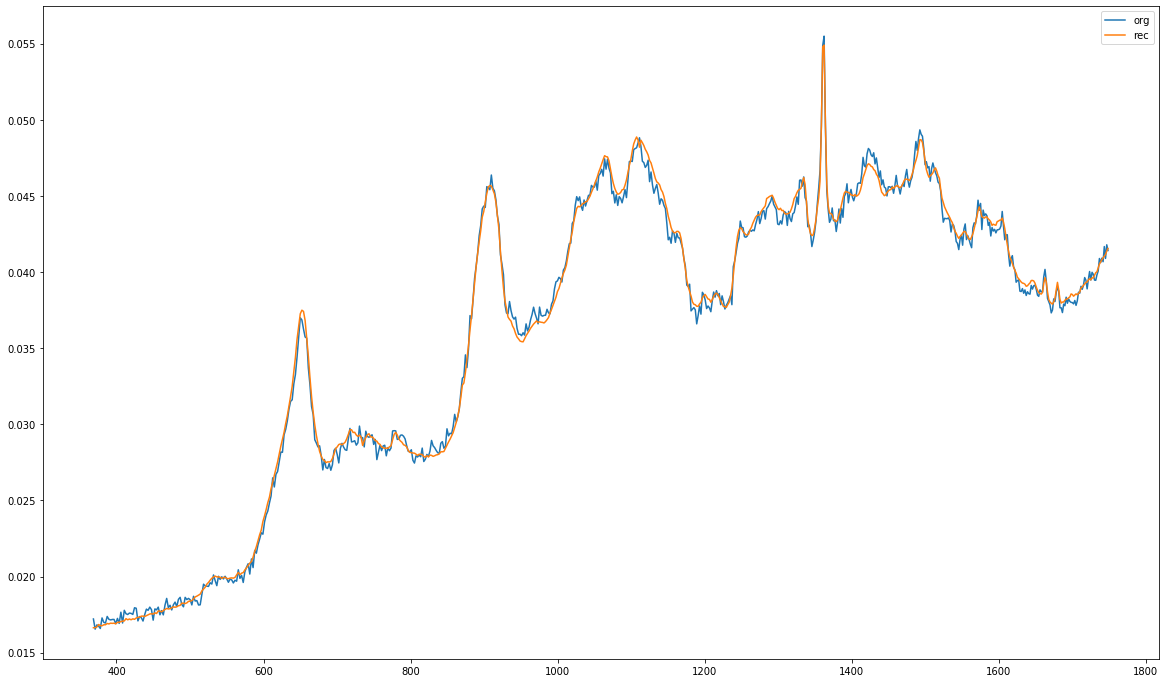

In [11]:
a = rvc.pca.inverse_transform(rvc.z)

plt.figure(figsize = (20,12))
plt.plot(wavelength, unit_vector_norm(X)[0],label='org')    
plt.plot(wavelength, a[0],label='rec')
plt.legend()   
plt.show()

In [12]:
mu = rvc.z.mean(0)
sigma = rvc.z.std(0)

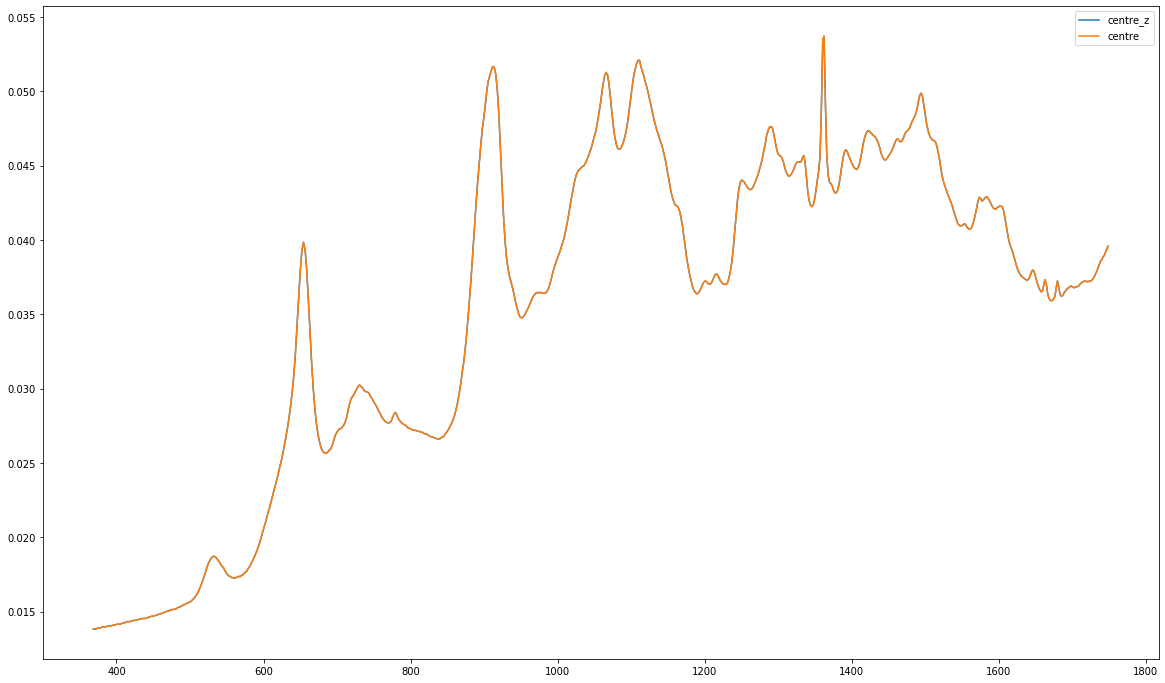

In [13]:
plt.figure(figsize = (20,12))
plt.plot(wavelength, rvc.pca.inverse_transform(mu), label='centre_z')
plt.plot(wavelength, unit_vector_norm(X).mean(0),label='centre')  
plt.legend() 
plt.show()


[-0.03300081  0.00333352  0.01635032  0.03101032  0.00217905 -0.00012828]


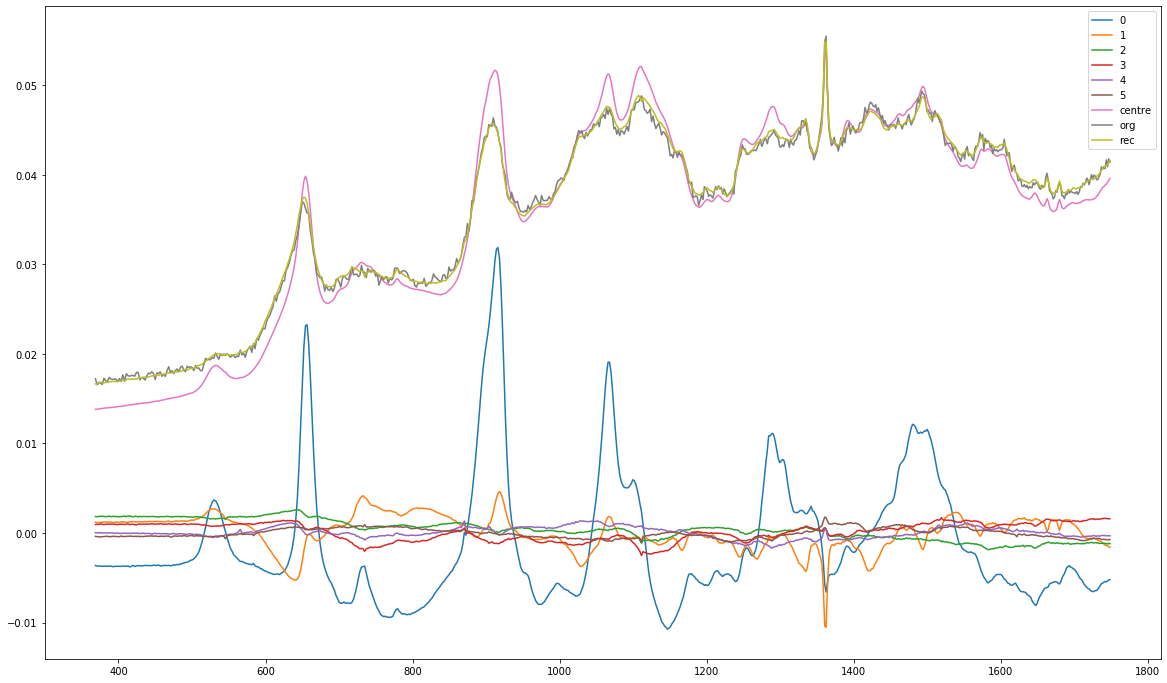

In [14]:
reconstruct = rvc.pca.inverse_transform(np.eye(6)*sigma*3) - unit_vector_norm(X).mean(0)

print(rvc.z[0])

plt.figure(figsize = (20,12))
for i, r in enumerate(reconstruct):
    plt.plot(wavelength, r, label=i)
plt.plot(wavelength, unit_vector_norm(X).mean(0),label='centre')    
plt.plot(wavelength, unit_vector_norm(X)[0],label='org')    
plt.plot(wavelength, a[0],label='rec')
plt.legend()
plt.show()


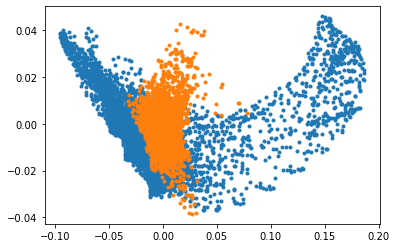

In [15]:
plt.plot(rvc.z[:,0], rvc.z[:,1], '.')
plt.plot(rvc.z[:,2], rvc.z[:,3], '.')